This is a working example of an MCS feature tracking algorithm that uses hourly precipitation and brithness temperature data to classify MCSs. Earlier versions of this tracking algorithm have been used in [Poujol et al. (2020)](https://link.springer.com/article/10.1007/s00382-020-05466-1) and [Prein et al. (2021) ](https://royalsocietypublishing.org/doi/full/10.1098/rsta.2019.0546).

The tracking algorithm contains three main steps:


*   Create a mask array containing zeros (no object) and ones (object) by thresholding the precipitation and brightness temperature field (Tb) field.
*   Identify connected features in the masked field and label them with a unique index. Grid cells are connected if they are adjacent in space and time (diagonal connections are allowed). 
*   Analyze each identified feateture if it fulfills the minimum requirements for MCSs that are provided by the user.

The mimimum requirements are associated with a minimum threshold that the feature must exceed (e.g., 2 mm/h precipitation rates), minimal maximum values (e.g. peak hourly rain rates), minimum size of the object, and a minimum duration for which the maximum value and object size must be exceeded.

The current example uses [GPM-IMERG v6](https://gpm.nasa.gov/data/imerg) precipitation and [MERGIR](https://disc.gsfc.nasa.gov/datasets/GPM_MERGIR_1/summary) Tb observations for MCS tracking for June 1, 2016 over the Contigeous United States. Both datasets are averaged to hourly values (24-time slizes) and the 4 km MERGIR data is regridded to the GPM-IMERG grid. The resulting data is stored in the "DATA_all" numpy array which has the dimensions [time, latitude, longitude, variables]. This array is passed to the "MCStracking" function, which performs the tracking. A few example outputs from this function are visualized at the end of the notebook.

The "DATA_all" function returns a directory and a matrix and writes a netcdf file.


*   The "grMCSs" directory contains sub-directories for each MCS that was identified. Each of the sub-directories contains MCS characteristics such as the track, speed, or max. precipitation. We plot the statistics of this directory at the end of this notebook.
*   The "MCS_obj" variable is a nupy array that conains the labels of tracked MCSs. Each MCS has a unique index and non-MCS areas are set to zero. The dimensions of "MCS_obj" are [time, lat, lon]. This variable can also be found in the NetCDF file that is described below. 
*   The "20160701_CONUS-MCS-tracking.nc" file contains the original precipitation and Tb data that was used for the MCS detection and the labels of each feature that was identified. This file will give you a good overview how the MCSs look like and you can use its content if you would like to perform you own statistics on the data.



If users whant to use a different dataset for MCS tracking (e.g., model results) they have to read in and process the precipitation data into the same format as the "DATA_all" data.

Please send questions or comments concerning this code to Andreas Prein (prein@ucar.edu).





# Mesoscale Convective System (MCS) Feature Tracking 

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
import matplotlib.path as mplPath
import sys
from calendar import monthrange
import warnings
warnings.filterwarnings("ignore")
from itertools import groupby
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from pylab import *
import h5py as h5py

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr
import netCDF4

In [ ]:
!pip install cartopy
import cartopy.crs as ccrs
!pip install --upgrade --no-cache-dir gdown

     |████████████████████████████████| 10.8 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 34.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 26.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 25.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.2 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516281 sha256=ef07020f874ec061246481ed3316a3b6a5830b854a8751bc9d1a3262707ee03f
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
  Install

### Download nescessary functions and example data

In [ ]:
# Download Tracking_Functions
!gdown 14-FI3CDSsYGfwBlb2hQ3wk4jj2lqJAgB
# Download IMERG
size = 0
while size <= 20000000:
    !gdown 1usC1Lo9AV4B7LQwb6oOAQe71xd9_BN2y
    size = os.path.getsize('CONUS_3B-HHR.MS.MRG.3IMERG.20160701.tar.gz')
!tar -xf CONUS_3B-HHR.MS.MRG.3IMERG.20160701.tar.gz
# Download GPM_MERGIR
size = 0
while size <= 20000000:
    !gdown 14Jk_j62wB9wl7EWypmULjUNkDYh3tjrl
    size = os.path.getsize('CONUS_merg_20160701_4km-pixel.tar.gz')
!tar -xf CONUS_merg_20160701_4km-pixel.tar.gz

Downloading...
From: https://drive.google.com/uc?id=14-FI3CDSsYGfwBlb2hQ3wk4jj2lqJAgB
To: /content/Tracking_Functions.py
100% 87.9k/87.9k [00:00<00:00, 37.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1usC1Lo9AV4B7LQwb6oOAQe71xd9_BN2y
To: /content/CONUS_3B-HHR.MS.MRG.3IMERG.20160701.tar.gz
100% 23.0M/23.0M [00:00<00:00, 51.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=14Jk_j62wB9wl7EWypmULjUNkDYh3tjrl
To: /content/CONUS_merg_20160701_4km-pixel.tar.gz
100% 46.1M/46.1M [00:00<00:00, 55.5MB/s]


In [ ]:
#### Functions from "Tracking_Function.py" file
from Tracking_Functions import ObjectCharacteristics
from Tracking_Functions import interp_weights
from Tracking_Functions import interpolate
from Tracking_Functions import detect_local_minima
from Tracking_Functions import Feature_Calculation
from Tracking_Functions import haversine
from Tracking_Functions import BreakupObjects
from Tracking_Functions import ConnectLon
from Tracking_Functions import ReadERA5
from Tracking_Functions import minimum_bounding_rectangle 
from Tracking_Functions import is_land 
from Tracking_Functions import DistanceCoord 
from Tracking_Functions import MultiObjectIdentification
from Tracking_Functions import readIMERG
from Tracking_Functions import readMERGIR
from Tracking_Functions import MCStracking

In [ ]:
# ###  USER MODIFY SECTION
DataName = 'IMERG' # common grid name
FocusRegion = [50, -60, 22, -130] #  N, E, S, W
Variables = ['PR','Tb']

# target grid 
sTarGrid ='IMERG'         # name of target grid
dT = 1                    # temporal resolution of data for tracking in hours

# MINIMUM REQUIREMENTS FOR FEATURE DETECTION
# precipitation tracking options
SmoothSigmaP = 0          # Gaussion std for precipitation smoothing
Pthreshold = 2            # precipitation threshold [mm/h]
MinTimePR = 3             # minum lifetime of PR feature in hours
MinAreaPR = 5000          # minimum area of precipitation feature in km2

# Brightness temperature (Tb) tracking setup
SmoothSigmaC = 0          # Gaussion std for Tb smoothing
Cthreshold = 241          # minimum Tb of cloud shield
MinTimeC = 9              # minium lifetime of cloud shield in hours
MinAreaC = 40000          # minimum area of cloud shield in km2

# MCs detection
MCS_Minsize = MinAreaPR   # minimum area of MCS precipitation object in km2
MCS_minPR = 10            # minimum max precipitation in mm/h
MCS_MinPeakPR = 10        # Minimum lifetime peak of MCS precipitation
CL_MaxT = 225             # minimum brightness temperature
CL_Area = MinAreaC        # min cloud area size in km2
MCS_minTime = 4           # minimum lifetime of MCS

In [ ]:
# ===============================================
# Setup variables for computation

StartDay = datetime.datetime(2016, 7, 1,0)
StopDay = datetime.datetime(2016, 7, 1,23)

TimeHH=pd.date_range(StartDay, end=StopDay, freq='h')
TimeMM=pd.date_range(StartDay, end=StopDay + datetime.timedelta(days=1), freq='m')
TimeDD = pd.date_range(StartDay, end=StopDay, freq='d')
TimeBT = pd.date_range(StartDay, end=StopDay, freq='h')
Time = pd.date_range(StartDay, end=StopDay, freq=str(dT)+'h')
Years = np.unique(TimeMM.year)
iHHall = np.array(range(len(TimeHH)))

# ### Read the target grid
dataset = h5py.File('CONUS_3B-HHR.MS.MRG.3IMERG.20160701-S000000-E002959.0000.V06B.nc', mode='r')
Lat= dataset['Grid/lat'][:]
Lon= dataset['Grid/lon'][:]
Lon,Lat = np.meshgrid(Lon,Lat)

if (FocusRegion[1] > 0) & (FocusRegion[3] < 0):
    # region crosses zero meridian
    iRoll = np.sum(Lon[0,:] < 0)
else:
    iRoll=0
Lon = np.roll(Lon,iRoll, axis=1)

iNorth = np.argmin(np.abs(Lat[:,0] - FocusRegion[0]))
iSouth = np.argmin(np.abs(Lat[:,0] - FocusRegion[2]))+1
iEast = np.argmin(np.abs(Lon[0,:] - FocusRegion[1]))+1
iWest = np.argmin(np.abs(Lon[0,:] - FocusRegion[3]))
print(iNorth,iSouth,iWest,iEast)

Lon = Lon[iSouth:iNorth,iWest:iEast]
Lat = Lat[iSouth:iNorth,iWest:iEast]

Mask = np.copy(Lon); Mask[:]=1
DATA_all = np.zeros((len(Time),Lon.shape[0],Lon.shape[1],len(Variables))); DATA_all[:] = np.nan

249 1 0 700


### Read Example Precipitation from IMERG and Tb from MERGIR

In [ ]:
DATA_all[:,:,:,Variables.index('PR')] = readIMERG(TimeHH,
                                                  Lon,
                                                  Lat,
                                                  iNorth,
                                                  iEast,
                                                  iSouth,
                                                  iWest,
                                                  dT)

DATA_all[:,:,:,Variables.index('Tb')] = readMERGIR(TimeBT,
                                                  Lon,
                                                  Lat,
                                                  dT,
                                                  FocusRegion)

# Mask out the focus domain if needed
DATA_all[:,Mask == 0,:] = np.nan

100%|██████████| 24/24 [00:00<00:00, 79.68it/s]


687 1 0 1925


100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


### Perform MCS Tracking

In [ ]:
NCfile = '20160701_CONUS-MCS-tracking.nc'
!rm $NCfile
grMCSs, MCS_obj = MCStracking(DATA_all,
                              Time,
                              Lon,
                              Lat,
                              Variables,
                              dT,
                              SmoothSigmaP = SmoothSigmaP,
                              Pthreshold = Pthreshold,
                              MinTimePR = MinTimePR,
                              MinAreaPR = MinAreaPR,
                              SmoothSigmaC = SmoothSigmaC,
                              Cthreshold = Cthreshold,
                              MinTimeC = MinTimeC,
                              MinAreaC = MinAreaC,
                              MCS_Minsize = MCS_Minsize,
                              MCS_minPR = MCS_minPR,
                              MCS_MinPeakPR = MCS_MinPeakPR,
                              CL_MaxT = CL_MaxT,
                              CL_Area = CL_Area,
                              MCS_minTime = MCS_minTime,
                              NCfile = NCfile)

rm: cannot remove '20160701_CONUS-MCS-tracking.nc': No such file or directory
        track  precipitation
            944 precipitation object found
            Loop over 18 objects
        track  clouds
            1343 cloud object found
        break up long living cloud shield objects that heve many elements
            Loop over 15 objects
        check if pr objects quallify as MCS
            Loop over 7 objects
 
Save the object masks into a joint netCDF
Saved: 20160701_CONUS-MCS-tracking.nc


### Plot Some of the Outputs

In [ ]:
import matplotlib.colors as mcolors
clevs = [0, 1, 2, 5, 7, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

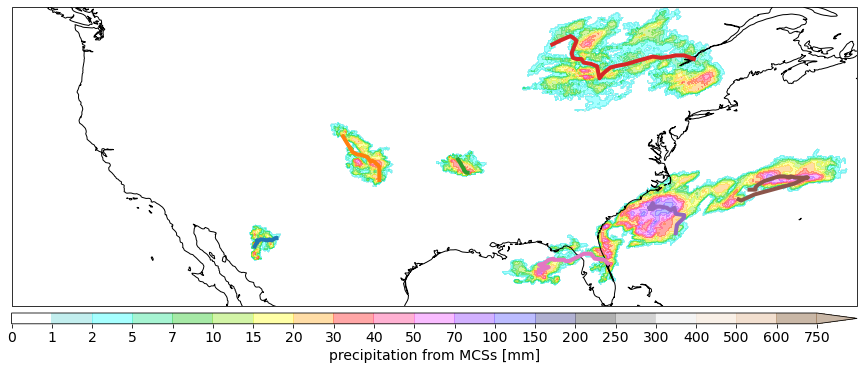

In [ ]:
# Plot MCS Tracks
fig = plt.figure(figsize=(20,5))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.10, right=0.96,
   bottom=0.10, top=0.93,
   wspace=0.08, hspace=0.2)
plt.rcParams.update({'font.size': 14})
proj = ccrs.PlateCarree() #ccrs.Robinson() 
ax = plt.subplot(gs1[0,0], projection=proj)

for ii in range(len(grMCSs.keys())):
  LatLonTrack = grMCSs[list(grMCSs.keys())[ii]]['rgrMassCentLatLon']
  plt.plot(LatLonTrack[:,0],LatLonTrack[:,1], transform=ccrs.PlateCarree(), lw=4)

PR_from_MCSs = np.copy(DATA_all[:,:,:,Variables.index('PR')])
PR_from_MCSs[MCS_obj == 0] = 0

# plot precipitatoin from MCSs
Levels = np.linspace(0,100,21)
cs = plt.contourf(Lon, Lat, np.sum(PR_from_MCSs, axis=0), transform=ccrs.PlateCarree(), 
             cmap=cmap, norm=norm, levels=clevs, extend='max', alpha=0.35)
# plot colortable
pos1 = ax.get_position()
CbarAx = axes([pos1.x0, 0.05, pos1.width, 0.03])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=clevs)
cb.set_label('precipitation from MCSs [mm]') #, fontsize=12)

ax.coastlines()

### Plot MCS Precipitation Area Size, Spee, and Peak PR

Text(0.5, 0, 'Time [hours]')

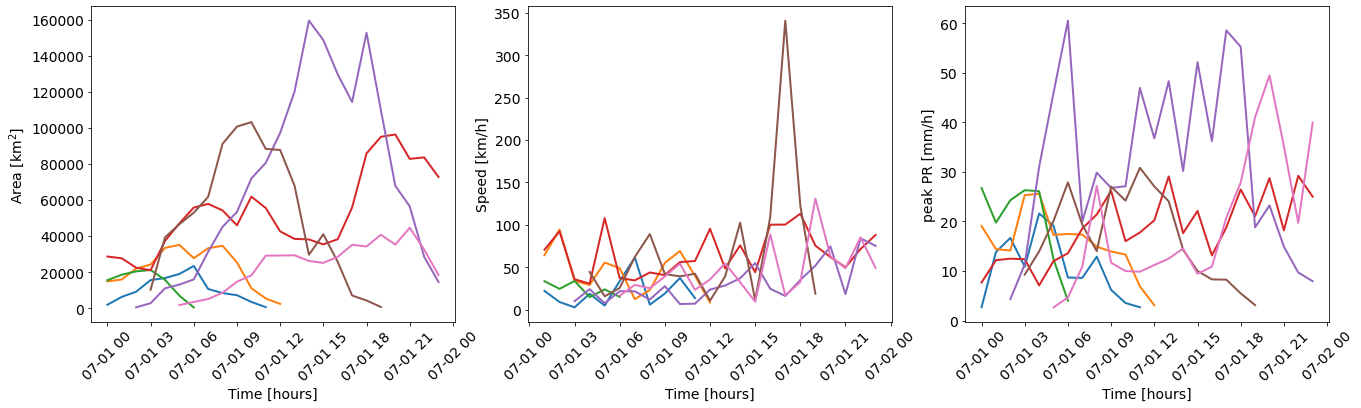

In [ ]:
fig = plt.figure(figsize=(20,6))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.10, right=0.96,
   bottom=0.2, top=0.93,
   wspace=0.2, hspace=0.2)
plt.rcParams.update({'font.size': 14})

# Plot size
ax = plt.subplot(gs1[0,0])
for ii in range(len(grMCSs.keys())):
  MCStime = grMCSs[list(grMCSs.keys())[ii]]['TimeAct']
  MCSsice = grMCSs[list(grMCSs.keys())[ii]]['rgrSize']
  plt.plot(MCStime, MCSsice/1000**2, lw=2)

plt.ylabel('Area [km$^2$]')
plt.xlabel('Time [hours]')
plt.xticks(rotation = 45)

# plot speed
ax = plt.subplot(gs1[0,1])
for ii in range(len(grMCSs.keys())):
  MCStime = grMCSs[list(grMCSs.keys())[ii]]['TimeAct'][1:]
  MCSspeed = grMCSs[list(grMCSs.keys())[ii]]['rgrObjSpeed']
  plt.plot(MCStime, MCSspeed, lw=2)

plt.xticks(rotation = 45)
plt.ylabel('Speed [km/h]')
plt.xlabel('Time [hours]')

# plot peak precipitation
ax = plt.subplot(gs1[0,2])
for ii in range(len(grMCSs.keys())):
  MCStime = grMCSs[list(grMCSs.keys())[ii]]['TimeAct'][:]
  MCSmaxPR = grMCSs[list(grMCSs.keys())[ii]]['rgrPR_Max']
  plt.plot(MCStime, MCSmaxPR, lw=2)

plt.xticks(rotation = 45)
plt.ylabel('peak PR [mm/h]')
plt.xlabel('Time [hours]')